# Encoding Analysis

## Loading data and libs

In [1]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [2]:
import os
from src.pipeline import Pipeline, MultiPipeline
from mne_bids import BIDSPath
import mne, logging, scipy
import numpy as np
import pandas as pd
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA
from erpanalysis import ERPAnalysis
from encoding_analysis import P3_LinearModel
import seaborn as sns

In [3]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='003', session='P3', task='P3',datatype='eeg', suffix='eeg', root=bids_root)
pipeline = Pipeline(bids_path, verbose=logging.ERROR)
pipeline.load_data()
pipeline.set_montage()
pipeline.set_custom_events_mapping(task='P3')

## Initialize Pipeline and generate Epochs

In [4]:
pipeline.make_pipeline([
    SimpleMNEFilter(0.5, 50, 'firwin'),
    CleaningData(bids_path),
    PrecomputedICA(bids_path),
    ('reference', ['P9', 'P10']),
    ('resample', 512)
])
erp = ERPAnalysis(-0.1, 0.8, baseline=(None, 0), reject_by_annotation=True)
pipeline.compute_epochs(erp)

<Epochs |  333 events (all good), -0.0996094 - 0.800781 sec, baseline -0.0996094 – 0 sec, ~38.8 MB, data loaded,
 'response/correct/201': 152
 'response/error/202': 14
 'stimulus/A/freq/12': 5
 'stimulus/A/freq/13': 5
 'stimulus/A/freq/14': 6
 'stimulus/A/freq/15': 2
 'stimulus/A/rare/11': 7
 'stimulus/B/freq/21': 4
 'stimulus/B/freq/23': 7
 'stimulus/B/freq/24': 8
 'stimulus/B/freq/25': 8
 'stimulus/B/rare/22': 7
 'stimulus/C/freq/31': 10
 'stimulus/C/freq/32': 7
 'stimulus/C/freq/34': 3
 'stimulus/C/freq/35': 9
 'stimulus/C/rare/33': 7
 'stimulus/D/freq/41': 11
 'stimulus/D/freq/42': 7
 'stimulus/D/freq/43': 4
 'stimulus/D/freq/45': 6
 'stimulus/D/rare/44': 7
 'stimulus/E/freq/51': 8
 'stimulus/E/freq/52': 7
 'stimulus/E/freq/53': 6
 'stimulus/E/freq/54': 9
 'stimulus/E/rare/55': 7>

## Linear Modelling

 $$ y = intercept + \beta_0 * stimulus_B + \beta_1 * stimulus_C + \beta_2 * stimulus_D + \beta_3 * stimulus_E + \beta_4 * condition_{rare/freq} + \beta_5 * reaction_time $$

## First we will test without including reaction time

In [5]:
erp.epochs.equalize_event_counts(['stimulus', 'response']); # because we have one extra response
epochs = erp.epochs['stimulus'].get_data(picks=['Pz'])
y = epochs.copy() #(events * channels * trials)
y_avg = y.sum(axis=2) * 1e3# convert to minivolts

### Design Matrix

In [6]:
X = np.zeros([y.shape[0], 6]) # 6 because we have 5 betas
X[:,0] = 1 # intercept

### Linear equation solver without Regularization

In [7]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X[:,1:], y_avg) # we don't need to pass intercept
incpt, coef = reg.intercept_, reg.coef_
print("Info check: Intercept-only{}, mean:{}".format(incpt, np.mean(y_avg))) # check if it is same

Info check: Intercept-only[-0.06913468], mean:-0.06913467912509626


### Get events dataframe

In [8]:
df = P3_LinearModel.get_encoding_data(erp.epochs, 'stimulus', channels=['Pz'])
df

epochs stimulus condition  code            Pz
0         0        C      freq    14  3.099095e-06
1         1        C      freq    14  1.698761e-06
2         2        C      freq    13  2.247666e-06
3         3        C      freq    13  1.438000e-06
4         4        C      freq    13  3.481106e-07
..      ...      ...       ...   ...           ...
161     161        A      freq     5  5.002909e-06
162     162        A      freq     3 -3.911795e-07
163     163        A      freq     3  2.143839e-07
164     164        A      freq     3 -1.695817e-06
165     165        A      freq     5 -4.373625e-06

[166 rows x 5 columns]

Looking at the data

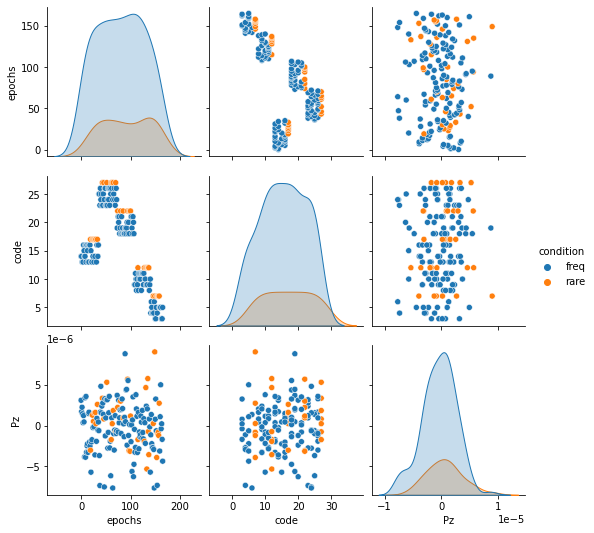

In [9]:
sns.pairplot(df, hue='condition')

We have unequal number of rare and freq evenets

In [10]:
X[np.where(df['condition'] =="rare"), 5] = 1
reg.fit(X[:,1:], df.Pz)

LinearRegression()

### Sanity check

<AxesSubplot:title={'center':'Hello'}>

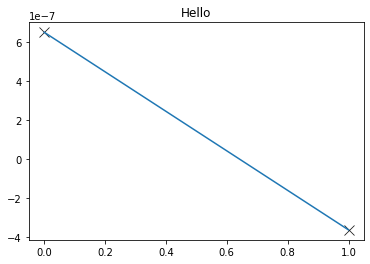

In [11]:
sns.lineplot([0,1],[df.Pz[df.condition=="rare"].mean(), df.Pz[df.condition=="freq"].mean()]).set(title='Hello');
sns.scatterplot(x=[0,1], y=[reg.coef_[4]+reg.intercept_, reg.intercept_],  s=100, color=".1", marker="x")

<AxesSubplot:xlabel='Pz', ylabel='Count'>

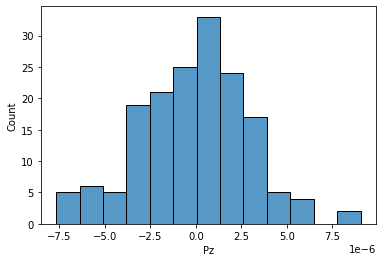

In [12]:
sns.histplot(df.Pz)

### Adding stimulus - A, B, C, D, E to the picture

<AxesSubplot:>

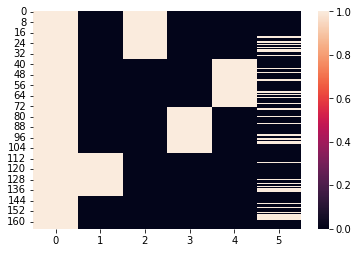

In [13]:
X[np.where(df['stimulus']=="B"),1] = 1
X[np.where(df['stimulus']=="C"),2] = 1
X[np.where(df['stimulus']=="D"),3] = 1
X[np.where(df['stimulus']=="E"),4] = 1
sns.heatmap(X) # design matrix heatmap

### Sanity check

In [14]:
x_vals = [0,1,2,3,4] # A, B, C, D, E
y_vals_rare = [df.Pz[(df.condition=="rare") & (df.stimulus=="A")].mean(), 
df.Pz[(df.condition=="rare") & (df.stimulus=="B")].mean(), df.Pz[(df.condition=="rare") & (df.stimulus=="C")].mean(),
df.Pz[(df.condition=="rare") & (df.stimulus=="D")].mean(), df.Pz[(df.condition=="rare") & (df.stimulus=="E")].mean()]

y_vals_freq = [df.Pz[(df.condition=="freq") & (df.stimulus=="A")].mean(), 
df.Pz[(df.condition=="freq") & (df.stimulus=="B")].mean(), df.Pz[(df.condition=="freq") & (df.stimulus=="C")].mean(),
df.Pz[(df.condition=="freq") & (df.stimulus=="D")].mean(), df.Pz[(df.condition=="freq") & (df.stimulus=="E")].mean()]

<AxesSubplot:>

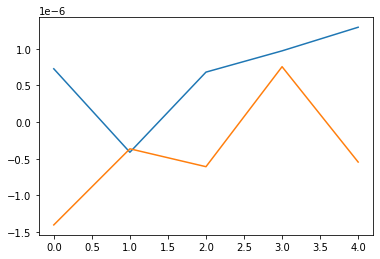

In [15]:
sns.lineplot(x_vals, y_vals_rare)
sns.lineplot(x_vals, y_vals_freq)
# sns.scatterplot(x=[0], y=[reg.intercept_[0]+ reg.coef_[0][0]])

In [16]:
reg.fit(X, y[:,0,:])
reg.intercept_, reg.coef_
betas = np.hstack((reg.intercept_.reshape(-1, 1), reg.coef_))

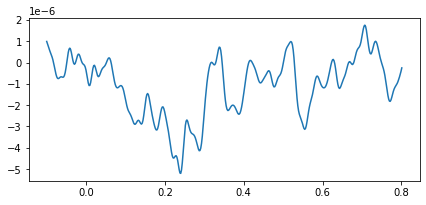

In [17]:
epocs = erp.epochs['stimulus/A'].copy()
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,3))
ax = sns.lineplot(x=epocs.times.reshape(-1), y=betas[:,0])

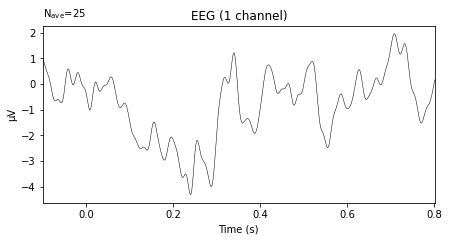

In [18]:
erp.epochs['stimulus/A'].average().plot(picks='Pz');

# Mass Univariate Analysis

Get reaction times

In [19]:
reaction_time = erp.epochs['stimulus'].events[:,0] - erp.epochs['response'].events[:,0]

In [20]:
X = np.hstack((X, reaction_time.reshape(-1, 1)))
X.shape

(166, 7)

I think I should add interaction valiable as well for the stimulus and the reaction time, but unfortunately it will be too complicated for me to decode then

<AxesSubplot:>

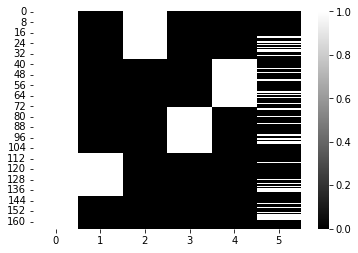

In [21]:
sns.heatmap(X[:,:6], cmap='gray')

## Usign MNE

In [22]:
from mne.stats import linear_regression, fdr_correction
predictors = ['intercept', 'stim_b', 'stim_c', 'stim_d', 'stim_e', 'condition', 'reaction_time']
df_mne = pd.DataFrame(X, columns=predictors)
df_mne

intercept  stim_b  stim_c  stim_d  stim_e  condition  reaction_time
0          1.0     0.0     1.0     0.0     0.0        0.0         -205.0
1          1.0     0.0     1.0     0.0     0.0        0.0         -236.0
2          1.0     0.0     1.0     0.0     0.0        0.0         -232.0
3          1.0     0.0     1.0     0.0     0.0        0.0         -428.0
4          1.0     0.0     1.0     0.0     0.0        0.0         -274.0
..         ...     ...     ...     ...     ...        ...            ...
161        1.0     0.0     0.0     0.0     0.0        0.0         -173.0
162        1.0     0.0     0.0     0.0     0.0        0.0         -248.0
163        1.0     0.0     0.0     0.0     0.0        0.0         -255.0
164        1.0     0.0     0.0     0.0     0.0        0.0         -255.0
165        1.0     0.0     0.0     0.0     0.0        0.0         -277.0

[166 rows x 7 columns]

In [23]:
res = linear_regression(erp.epochs['stimulus'], df_mne, names=predictors)

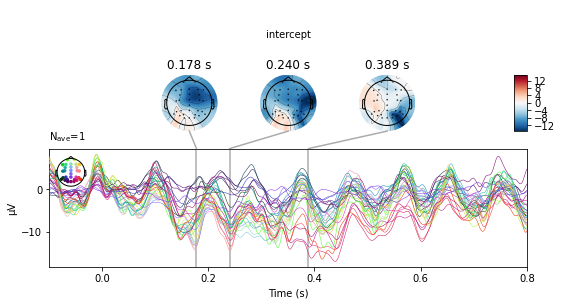

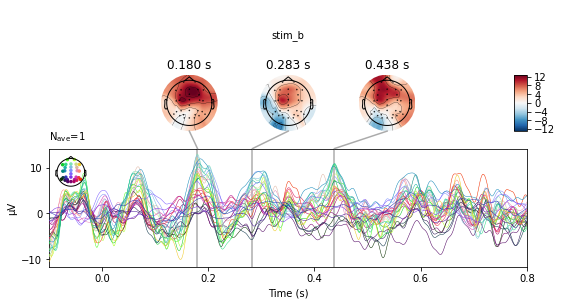

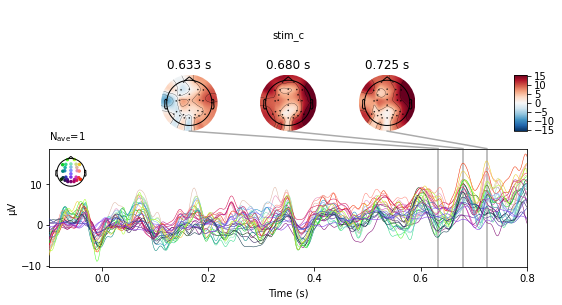

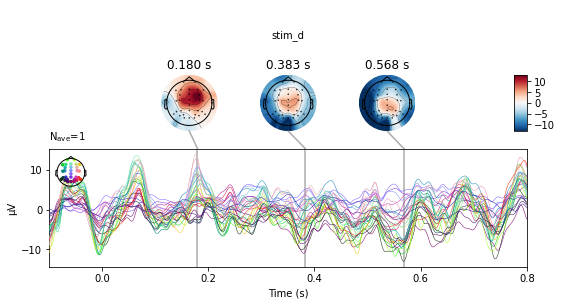

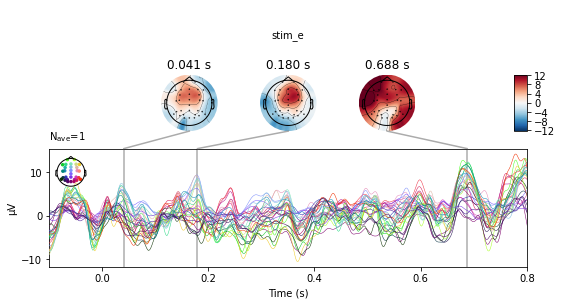

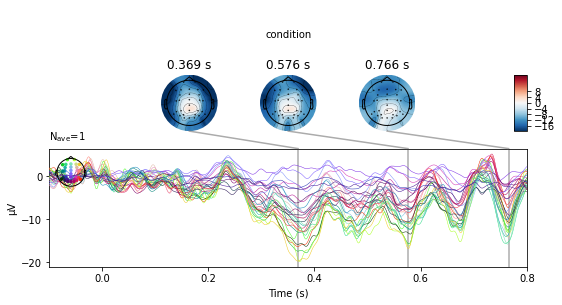

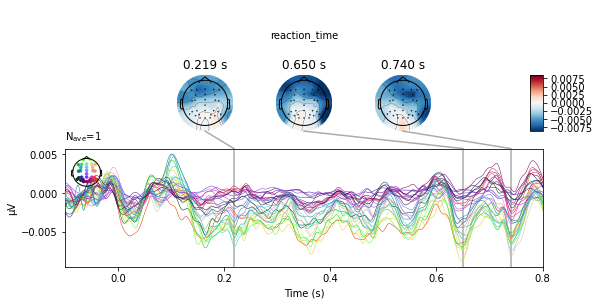

In [24]:
for pred in predictors:
    res[pred].beta.plot_joint(title=pred, ts_args=dict(time_unit='s'), topomap_args=dict(time_unit='s'));

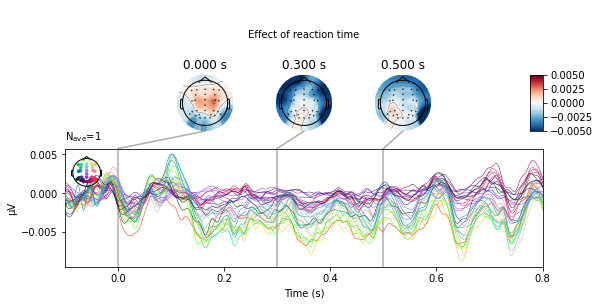

In [25]:
res['reaction_time'].beta.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);

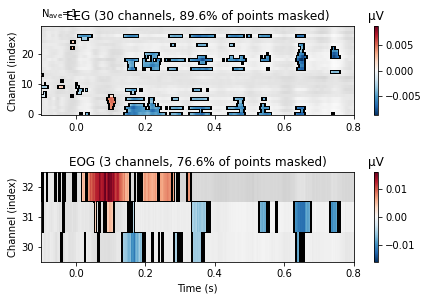

In [26]:
reject_H0, fdr_pvals = fdr_correction(res["reaction_time"].p_val.data)
evoked = res["reaction_time"].beta
evoked.plot_image(mask=reject_H0, time_unit='s');

## For all the subjects

In [27]:
pipelines = MultiPipeline(bids_root)
erp = ERPAnalysis(-0.1, 0.8, baseline=(None, 0), reject_by_annotation=True, all_subjects=True)
pipelines.start_erp_analysis(erp)

100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


ERPAnalysis(tmin=-0.1, tmax=0.8, baseline=(None, 0), reject_by_annotation=True, all_subjects=True, reject={})

In [28]:
encoder = P3_LinearModel()
pipelines.start_encoding_analysis(erp, encoder)

In [42]:
reaction_evoked = mne.combine_evoked([beta['reaction_time'].beta for beta in encoder.betas], weights='equal')
stim_a_evoked = mne.combine_evoked([beta['intercept'].beta for beta in encoder.betas], weights='equal')
stim_b_evoked = mne.combine_evoked([beta['stim_b'].beta for beta in encoder.betas], weights='equal')
stim_c_evoked = mne.combine_evoked([beta['stim_c'].beta for beta in encoder.betas], weights='equal')
stim_d_evoked = mne.combine_evoked([beta['stim_d'].beta for beta in encoder.betas], weights='equal')
stim_e_evoked = mne.combine_evoked([beta['stim_e'].beta for beta in encoder.betas], weights='equal')
condition_evoked = mne.combine_evoked([beta['condition'].beta for beta in encoder.betas], weights='equal')

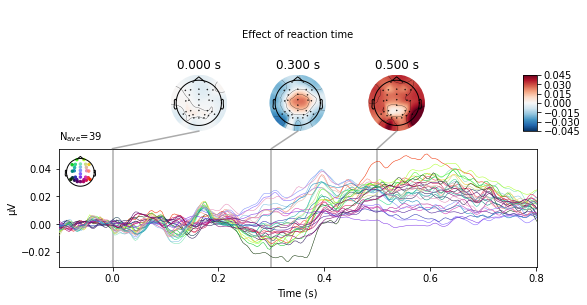

In [43]:
reaction_evoked.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);

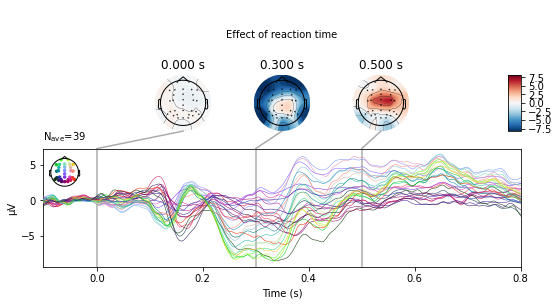

In [44]:
stim_a_evoked.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);

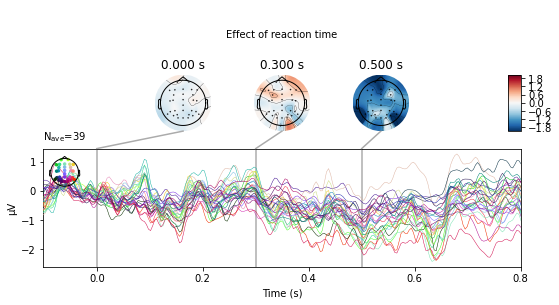

In [45]:
stim_b_evoked.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);

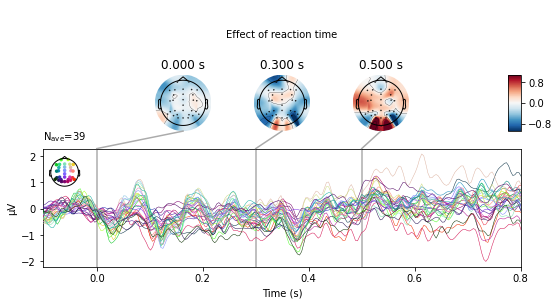

In [46]:
stim_c_evoked.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);

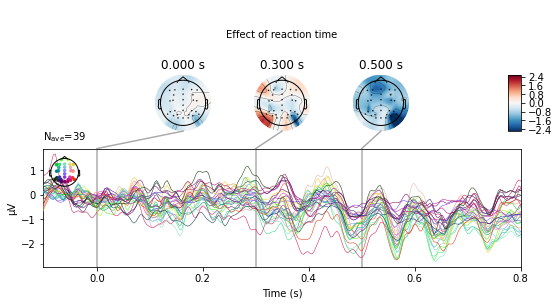

In [47]:
stim_d_evoked.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);

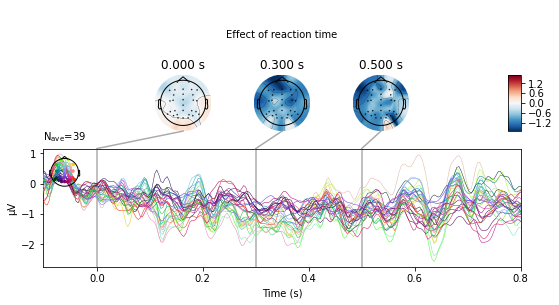

In [48]:
stim_e_evoked.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);

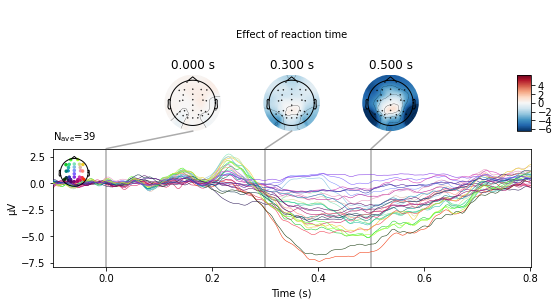

In [49]:
condition_evoked.plot_joint(title='Effect of reaction time', times=[0.0, 0.3, 0.5]);